In [1]:
#Importações
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Criando o data frame

In [3]:
# Função de extração dos dados e criação do DataFrame
def injetar_csvs_no_dataframe(csv_path):
    """
    Carrega todos os arquivos CSV do diretório Database CPGF no DataFrame CPGF_df,
    adicionando a coluna 'ARQUIVO ORIGEM' com o nome do arquivo csv original.
    """
    dfs = []
    csv_files = [f for f in os.listdir(csv_path) if f.lower().endswith('.csv')]
    for file in csv_files:
        file_path = os.path.join(csv_path, file)
        df_temp = pd.read_csv(file_path,sep=';',encoding='latin-1',low_memory=False)
        df_temp['ARQUIVO ORIGEM'] = file
        dfs.append(df_temp)
    CPGF_df = pd.concat(dfs, ignore_index=True)
    return CPGF_df

In [4]:
#Usando a função
csv_path = '../raw_data'
CPGF_df = injetar_csvs_no_dataframe(csv_path)

In [5]:
# Ajustando coluna de Data
CPGF_df['DATA TRANSAÇÃO'] = pd.to_datetime(CPGF_df['DATA TRANSAÇÃO'], format='%d/%m/%Y', errors='coerce')

# Ajustando coluna de Valores
CPGF_df['VALOR TRANSAÇÃO'] = CPGF_df['VALOR TRANSAÇÃO'].astype(str).str.replace('.', '').str.replace(',', '.')
CPGF_df['VALOR TRANSAÇÃO'] = pd.to_numeric(CPGF_df['VALOR TRANSAÇÃO'], errors='coerce').fillna(0)

In [6]:
CPGF_df = CPGF_df.drop_duplicates()

In [7]:
CPGF_df_limpo = CPGF_df.copy()

## Checklist e Análises

### Checklists básicos

In [ ]:
CPGF_df_limpo.info(verbose=True)

In [ ]:
CPGF_df_limpo.describe()

In [ ]:
CPGF_df_limpo.isnull().sum()

### Analisando os nulos mais a fundo

In [ ]:
# Confirmando que os nulos são as mesmas linhas
nulos_cpf = CPGF_df_limpo[CPGF_df_limpo['CPF PORTADOR'].isnull()]

# Verifica se, dentro dessas linhas, a Data também é nula
print(f"Total de nulos no CPF: {len(nulos_cpf)}")
print(f"Total de nulos na data de transação (dentro das linhas nulas de CPF): {nulos_cpf['DATA TRANSAÇÃO'].isnull().sum()}")

#### Vendo os tipos dos gastos

In [ ]:
# O que está escrito na coluna 'TRANSAÇÃO'
print("Tipos de Transação nos dados nulos:")
print(nulos_cpf['TRANSAÇÃO'].value_counts())

# O que está escrito na coluna 'NOME FAVORECIDO'
print("\nFavorecidos nos dados nulos:")
print(nulos_cpf['NOME FAVORECIDO'].value_counts())

# O que está escrito na coluna 'NOME PORTADOR'
print("\nNome do Portador nos dados nulos:")
print(nulos_cpf['NOME PORTADOR'].value_counts())


# O que está escrito na coluna 'NOME ÓRGÃO SUPERIOR'
print("\nNome do Orgão Superior nos dados nulos:")
print(nulos_cpf['NOME ÓRGÃO SUPERIOR'].value_counts())


# O que está escrito na coluna 'NOME ÓRGÃO'
print("\nNome do Orgão nos dados nulos:")
print(nulos_cpf['NOME ÓRGÃO'].value_counts())


# O que está escrito na coluna 'NOME UNIDADE GESTORA'
print("\nNome da Unidade Gestora nos dados nulos:")
print(nulos_cpf['NOME UNIDADE GESTORA'].value_counts())

#### Vendo as datas faltantes

In [ ]:
df_sem_data = CPGF_df_limpo[CPGF_df_limpo['DATA TRANSAÇÃO'].isnull()].copy()
distribuicao_temporal = df_sem_data.groupby(['ANO EXTRATO', 'MÊS EXTRATO']).size().reset_index(name='Quantidade')

# Ordenar
distribuicao_temporal = distribuicao_temporal.sort_values(['ANO EXTRATO', 'MÊS EXTRATO'])

# Gráfico de barras
distribuicao_temporal['Data_Ref'] = distribuicao_temporal['ANO EXTRATO'].astype(str) + '-' + distribuicao_temporal['MÊS EXTRATO'].astype(str).str.zfill(2)

plt.figure(figsize=(15, 6))
sns.barplot(data=distribuicao_temporal, x='Data_Ref', y='Quantidade', color='gray')
plt.xticks(rotation=45)
plt.title('Volume de Transações "Sem Data" (Sigilosas) por Mês de Extrato')
plt.xlabel('Mês de Referência (Extrato)')
plt.ylabel('Quantidade de Transações')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### **Proposta para os nulos:** Adicionar uma coluna que indicará se o gasto é sigiloso  e outra indicado se a data é imputada (consideramos que colocaremos na nada desses casos sempre ano-mes-01)
_Observação: Ao criar a feature DIA_DA_SEMANA, ele deve usar uma lógica condicional tipo if row['DATA_IMPUTADA'] == 1: return -1_

### Analisando Estados

In [ ]:
CPGF_df_limpo['NOME ÓRGÃO'].value_counts()

In [ ]:
CPGF_df_limpo['NOME UNIDADE GESTORA'].value_counts()

In [ ]:
termos_especificos = {
    # === CORREÇÕES DE BUGS E CASOS ESPECÍFICOS (Prioridade) ===
    'PARADA DE LUCAS': 'RJ',
    'CATARINENSE': 'SC',
    'RIO DO SUL': 'SC',
    'CONCEICAO S/A': 'RS',      # Hospital Conceição
    'TRIANGULO MINEIRO': 'MG',
    'FOZ DO IGUACU': 'PR',
    'VALES DO S.FRANC': 'DF',   # Codevasf (Sede)
    'PARNAIBA': 'DF',           # Codevasf (Sede)
    'COMUNICACAO S.A': 'DF',    # EBC
    'RECURSOS MINERAIS': 'DF',  # CPRM
    'DITEC/DPF': 'DF',

    # === CAPITAIS E GRANDES CIDADES (Mapeamento Urbano) ===
    # -- Região Norte --
    'MANAUS': 'AM', 'AMAZONIA': 'AM',
    'BELEM': 'PA', 'SANTAREM': 'PA', 'MARABA': 'PA', 'ANANINDEUA': 'PA',
    'PORTO VELHO': 'RO',
    'RIO BRANCO': 'AC',
    'BOA VISTA': 'RR',
    'MACAPA': 'AP',
    'PALMAS': 'TO', 'ARAGUAINA': 'TO',

    # -- Região Nordeste --
    'SAO LUIS': 'MA', 'IMPERATRIZ': 'MA',
    'TERESINA': 'PI', 'PARNAIBA': 'PI', # Cuidado: Parnaíba cidade vs Rio
    'FORTALEZA': 'CE', 'SOBRAL': 'CE', 'JUAZEIRO DO NORTE': 'CE',
    'NATAL': 'RN', 'MOSSORO': 'RN',
    'JOAO PESSOA': 'PB', 'CAMPINA GRANDE': 'PB',
    'RECIFE': 'PE', 'JABOATAO': 'PE', 'PETROLINA': 'PE', 'CARUARU': 'PE', 'JOAQUIM NABUCO': 'PE',
    'MACEIO': 'AL', 'ARAPIRACA': 'AL',
    'ARACAJU': 'SE',
    'SALVADOR': 'BA', 'FEIRA DE SANTANA': 'BA', 'VITORIA DA CONQUISTA': 'BA', 'CAMACARI': 'BA', 'ILHEUS': 'BA', 'GONCALO MONIZ': 'BA',

    # -- Região Centro-Oeste --
    'CUIABA': 'MT', 'VARZEA GRANDE': 'MT', 'RONDONOPOLIS': 'MT',
    'CAMPO GRANDE': 'MS', 'DOURADOS': 'MS', 'CORUMBA': 'MS',
    'GOIANIA': 'GO', 'APARECIDA DE GOIANIA': 'GO', 'ANAPOLIS': 'GO', 'RIO VERDE': 'GO', 'CRISTALINA': 'GO', 'CATALAO': 'GO',

    # -- Região Sudeste --
    'BELO HORIZONTE': 'MG', 'UBERLANDIA': 'MG', 'CONTAGEM': 'MG', 'JUIZ DE FORA': 'MG', 'BETIM': 'MG', 'OURO PRETO': 'MG', 'LAVRAS': 'MG', 'ITAJUBA': 'MG', 'ALFENAS': 'MG', 'S.J.DEL-REI': 'MG',
    'VITORIA': 'ES', 'VILA VELHA': 'ES', 'SERRA': 'ES',
    'RIO DE JANEIRO': 'RJ', 'NITEROI': 'RJ', 'SAO GONCALO': 'RJ', 'DUQUE DE CAXIAS': 'RJ', 'NOVA IGUACU': 'RJ', 'PETROPOLIS': 'RJ', 'VOLTA REDONDA': 'RJ', 'ANGRA DOS REIS': 'RJ', 'ITATIAIA': 'RJ', 'CEFET/RJ': 'RJ', 'ILHA DAS FLORES': 'RJ', 'AGULHAS NEGRAS': 'RJ', 'RESENDE': 'RJ', 'FLUMINENSE': 'RJ', 'PEDRO II': 'RJ',
    'SAO PAULO': 'SP', 'GUARULHOS': 'SP', 'CAMPINAS': 'SP', 'SAO BERNARDO': 'SP', 'SANTO ANDRE': 'SP', 'OSASCO': 'SP', 'RIBEIRAO PRETO': 'SP', 'SOROCABA': 'SP', 'SANTOS': 'SP', 'SAO CARLOS': 'SP', 'TAUBATE': 'SP',

    # -- Região Sul --
    'CURITIBA': 'PR', 'LONDRINA': 'PR', 'MARINGA': 'PR', 'PONTA GROSSA': 'PR', 'CASCAVEL': 'PR',
    'FLORIANOPOLIS': 'SC', 'JOINVILLE': 'SC', 'BLUMENAU': 'SC', 'CHAPECO': 'SC', 'ITAJAI': 'SC',
    'PORTO ALEGRE': 'RS', 'CAXIAS DO SUL': 'RS', 'PELOTAS': 'RS', 'CANOAS': 'RS', 'SANTA MARIA': 'RS', 'RIO GRANDE': 'RS', 'PAMPA': 'RS',

    # -- Distrito Federal (Termos Nacionais/Sedes) --
    'BRASILIA': 'DF', 'INTELIGENCIA': 'DF', 'ABIN': 'DF', 'CHICO MENDES': 'DF',
    'NACIONAL': 'DF', 'BRASILEIRA': 'DF', 'CENTRAL': 'DF', 'SUPERIOR': 'DF',
    'SIT': 'DF', 'CODEVASF': 'DF',
    'FNDE': 'DF', 'INEP': 'DF', 'CAPES': 'DF', 'CNPQ': 'DF', 'EBSERH': 'DF',
    'ESPLANADA': 'DF', 'ADMINISTRACAO INTERNA': 'DF'
}

# SIGLAS DE ESTADOS
estados_map = {
    'AC': ['ACRE', '/AC', '- AC'], 'AL': ['ALAGOAS', '/AL', '- AL'],
    'AP': ['AMAPA', '/AP', '- AP'], 'AM': ['AMAZONAS', '/AM', '- AM'],
    'BA': ['BAHIA', '/BA', '- BA'], 'CE': ['CEARA', '/CE', '- CE'],
    'DF': ['DISTRITO FEDERAL', 'BRASILIA', '/DF', '- DF', 'PRESIDENCIA', 'MINISTERIO', 'COORDENACAO'],
    'ES': ['ESPIRITO SANTO', '/ES', '- ES'], 'GO': ['GOIAS', '/GO', '- GO'],
    'MA': ['MARANHAO', '/MA', '- MA'], 'MT': ['MATO GROSSO', '/MT', '- MT'],
    'MS': ['MATO GROSSO DO SUL', '/MS', '- MS'], 'MG': ['MINAS GERAIS', '/MG', '- MG'],
    'PB': ['PARAIBA', '/PB', '- PB'], 'PR': ['PARANA', '/PR', '- PR'], 'PA': ['PARA', '/PA', '- PA'],
    'PE': ['PERNAMBUCO', '/PE', '- PE'], 'PI': ['PIAUI', '/PI', '- PI'],
    'RJ': ['RIO DE JANEIRO', '/RJ', '- RJ'],
    'RN': ['RIO GRANDE DO NORTE', '/RN', '- RN'], 'RS': ['RIO GRANDE DO SUL', '/RS', '- RS'],
    'RO': ['RONDONIA', '/RO', '- RO'], 'RR': ['RORAIMA', '/RR', '- RR'],
    'SC': ['SANTA CATARINA', '/SC', '- SC'], 'SP': ['SAO PAULO', '/SP', '- SP'],
    'SE': ['SERGIPE', '/SE', '- SE'], 'TO': ['TOCANTINS', '/TO', '- TO']
}
siglas_confiaveis = list(estados_map.keys())

def estimar_estado(linha):
    texto = str(linha['NOME ÓRGÃO']) + " " + str(linha['NOME UNIDADE GESTORA'])
    texto = texto.upper()

    # de/para com termos específicos
    for termo, uf in termos_especificos.items():
        if termo in texto:
            return uf

    # Limpeza de termos irrelevantes
    texto = texto.replace(" SEDE ", " ")
    texto = texto.replace("PARADA", "")

    #  Termos presidenciais
    termos_presidencia = ['GABINETE DE SEGURANCA', 'SECRETARIA DE ADMINISTRACAO/PR', 'PRESIDENCIA DA REPUBLICA']
    for termo in termos_presidencia:
        if termo in texto:
            return 'DF'

    # Busca com preposições
    padrao_preposicao = r'\b(NO|NA|DO|DA|DE|EM|AO)\s+(' + '|'.join(siglas_confiaveis) + r')\b'
    match = re.search(padrao_preposicao, texto)
    if match:
        return match.group(2)

    #  Busca por siglas ou nomes completos
    for uf, termos in estados_map.items():
        for termo in termos:
            if len(termo) > 3:
                if termo in texto:
                    return uf
            elif re.search(r'\b' + re.escape(termo) + r'\b', texto):
                 return uf

    return 'UNIÃO'


CPGF_df_limpo['ESTADO_ESTIMADO'] = CPGF_df_limpo.apply(estimar_estado, axis=1)

print("\n--- Ranking Final dos Estados ---")
print(CPGF_df_limpo['ESTADO_ESTIMADO'].value_counts().head(25))

In [ ]:
summary_estado = (
    CPGF_df_limpo.groupby("ESTADO_ESTIMADO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("sum", ascending=False)
)

summary_estado

#### **Proposta para os Estados:** Fazer a validação somente por nome de cidade e manter os postos regionais (que em sua maioria são militares) como união

### Análise por valor da transação

In [ ]:
plt.boxplot(CPGF_df_limpo['VALOR TRANSAÇÃO'])
plt.show();

In [ ]:
# Visão por órgão superior
summary_orgao = (
    CPGF_df_limpo.groupby("NOME ÓRGÃO SUPERIOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_orgao

In [ ]:
# Visão por unidade gestora
summary_unidade_gestora = (
    CPGF_df_limpo.groupby("NOME UNIDADE GESTORA")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_unidade_gestora

In [ ]:
# Visão por tipo de transação
summary_transacao = (
    CPGF_df_limpo.groupby("TRANSAÇÃO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_transacao

In [ ]:
# Visão por portador
CPGF_df_limpo['CHAVE_PORTADOR'] = CPGF_df_limpo['CPF PORTADOR'] + CPGF_df_limpo['NOME PORTADOR']
summary_portador = (
    CPGF_df_limpo.groupby("CHAVE_PORTADOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_portador

In [ ]:
# Visão por favorecido
summary_favorecido = (
    CPGF_df_limpo.groupby("CNPJ OU CPF FAVORECIDO")["VALOR TRANSAÇÃO"]
      .agg([
          ("count", "count"),
          ("min", "min"),
          ("Q1", lambda x: x.quantile(0.25)),
          ("median", "median"),
          ("Q3", lambda x: x.quantile(0.75)),
          ("max", "max"),
          ("mean", "mean"),
          ("sum", "sum"),
          ("std", "std")
      ])
      .sort_values("median", ascending=False)
)

summary_favorecido

### Analise de tipo de transação (Saque)

In [ ]:
# Filtrando apenas as transações de Saque
saque_dinheiro = CPGF_df_limpo[
    CPGF_df_limpo['TRANSAÇÃO'].isin([
        'SAQUE CASH/ATM BB',
        'SAQUE - INT$ - APRES',
        'SAQUE - R$ - APRES',
    ])
]

# Agrupando e somando
saque_dinheiro_por_orgao = (
    saque_dinheiro.groupby(['CPF PORTADOR', 'NOME ÓRGÃO'])['VALOR TRANSAÇÃO']
    .agg(['count', 'sum'])
    .sort_values('sum', ascending=False)
)

# Exibindo o resultado
saque_dinheiro_por_orgao

In [ ]:
gasto_por_orgao = (
    CPGF_df_limpo
        .groupby('NOME ÓRGÃO')['VALOR TRANSAÇÃO']
        .agg(['count', 'sum', 'mean'])
        .sort_values('sum', ascending=False)
)
gasto_por_orgao

##  Alterações na base de dado

### Padding de CPF/CNPJ
Pelos dados mais comuns é possível entender que muitos dos dados de documentos do favorecido estão dessa forma por falta do 0 à esquerda. Exemplo '1060735000173' tem como final um claro comportamento de documento CNPJ /0001-73 faltando somente um zero à esquera para completar o documento.
Portanto faremos um padding para equalizar os CPFs nos 11 digitos e os CNPJs nos 14:

In [ ]:
CPGF_df['CNPJ OU CPF FAVORECIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO'].astype(str)
CPGF_df.info()

In [ ]:
tamanhos_problematicos = [2, 4, 6, 7, 8, 9, 10, 12, 13]
serie_tamanhos = CPGF_df['CNPJ OU CPF FAVORECIDO'].str.len()

CPGF_df['CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO']

mascara_cpf_fix = (serie_tamanhos >= 8) & (serie_tamanhos <= 10)
mascara_cnpj_fix = (serie_tamanhos == 12) | (serie_tamanhos == 13)

# Padding CPF
CPGF_df.loc[mascara_cpf_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO'][mascara_cpf_fix].str.pad(width=11, side='left', fillchar='0')

# Padding CNPJ
CPGF_df.loc[mascara_cnpj_fix, 'CNPJ OU CPF FAVORECIDO CORRIGIDO'] = CPGF_df['CNPJ OU CPF FAVORECIDO'][mascara_cnpj_fix].str.pad(width=14, side='left', fillchar='0')

In [ ]:
# Classificação do tipo de favorecido
condicoes = [(serie_tamanhos == 11), (serie_tamanhos == 14), (serie_tamanhos == 2)]
categorias = ['CPF','CNPJ','NAO_INFORMADO']

CPGF_df['TIPO FAVORECIDO'] = np.select(condicoes,categorias,default='INVALIDO')

In [ ]:
# Drop nos favorecidos não classificados
linhas_para_dropar = CPGF_df[CPGF_df['TIPO FAVORECIDO'] == 'INVALIDO'].index
CPGF_df = CPGF_df.drop(linhas_para_dropar)

In [ ]:
# Analisando a nova feature
print("Contagem de linhas por categoria:")
print(CPGF_df['TIPO FAVORECIDO'] .value_counts())

In [ ]:
# Substituindo a CNPJ OU CPF FAVORECIDO pela CNPJ OU CPF FAVORECIDO CORRIGIDO
CPGF_df = CPGF_df.drop(columns=['CNPJ OU CPF FAVORECIDO'])
CPGF_df = CPGF_df.rename(columns={'CNPJ OU CPF FAVORECIDO CORRIGIDO':'CNPJ OU CPF FAVORECIDO'})

### Criar coluna para dados sigilosos

In [8]:
CPGF_df['DADO_SIGILOSO'] = (CPGF_df['NOME FAVORECIDO'] == 'Sigiloso').astype(int)

print(CPGF_df['DADO_SIGILOSO'].value_counts())

DADO_SIGILOSO
0    289417
1     17890
Name: count, dtype: int64


### Imputar datas faltantes

In [9]:
datas_nulas = CPGF_df['DATA TRANSAÇÃO'].isnull()

datas_artificiais = pd.to_datetime(
    CPGF_df.loc[datas_nulas, 'ANO EXTRATO'].astype(str) + '-' +
    CPGF_df.loc[datas_nulas, 'MÊS EXTRATO'].astype(str) + '-01'
)

CPGF_df.loc[datas_nulas, 'DATA TRANSAÇÃO'] = datas_artificiais

print(f"Linhas imputadas: {datas_nulas.sum()}")
print(f"Nulos restantes em DATA TRANSAÇÃO: {CPGF_df['DATA TRANSAÇÃO'].isnull().sum()}")

Linhas imputadas: 17890
Nulos restantes em DATA TRANSAÇÃO: 0


In [ ]:
CPGF_df.isnull().sum()

### Imputar estado

In [10]:
mapa_cidades = {
    # Rio de Janeiro (RJ)
    'RIO DE JANEIRO': 'RJ', 'NITEROI': 'RJ', 'SAO GONCALO': 'RJ',
    'DUQUE DE CAXIAS': 'RJ', 'NOVA IGUACU': 'RJ', 'PETROPOLIS': 'RJ',
    'VOLTA REDONDA': 'RJ', 'ANGRA DOS REIS': 'RJ', 'ITATIAIA': 'RJ',
    'RESENDE': 'RJ', 'PARADA DE LUCAS': 'RJ', 'FLUMINENSE': 'RJ',
    'PEDRO II': 'RJ', 'ILHA DAS FLORES': 'RJ', 'AGULHAS NEGRAS': 'RJ',

    # São Paulo (SP)
    'SAO PAULO': 'SP', 'GUARULHOS': 'SP', 'CAMPINAS': 'SP',
    'SAO BERNARDO': 'SP', 'SANTO ANDRE': 'SP', 'OSASCO': 'SP',
    'RIBEIRAO PRETO': 'SP', 'SOROCABA': 'SP', 'SANTOS': 'SP',
    'SAO CARLOS': 'SP', 'TAUBATE': 'SP',

    # Minas Gerais (MG)
    'BELO HORIZONTE': 'MG', 'UBERLANDIA': 'MG', 'JUIZ DE FORA': 'MG',
    'OURO PRETO': 'MG', 'LAVRAS': 'MG', 'ITAJUBA': 'MG', 'ALFENAS': 'MG',
    'SAO JOAO DEL REI': 'MG', 'S.J.DEL-REI': 'MG', 'TRIANGULO MINEIRO': 'MG',

    # Espírito Santo (ES)
    'VITORIA': 'ES', 'VILA VELHA': 'ES',

    # Rio Grande do Sul (RS)
    'PORTO ALEGRE': 'RS', 'CAXIAS DO SUL': 'RS', 'PELOTAS': 'RS',
    'CANOAS': 'RS', 'SANTA MARIA': 'RS', 'RIO GRANDE': 'RS',
    'CONCEICAO S/A': 'RS', 'PAMPA': 'RS',

    # Paraná (PR)
    'CURITIBA': 'PR', 'LONDRINA': 'PR', 'MARINGA': 'PR',
    'PONTA GROSSA': 'PR', 'CASCAVEL': 'PR', 'FOZ DO IGUACU': 'PR',

    # Santa Catarina (SC)
    'FLORIANOPOLIS': 'SC', 'JOINVILLE': 'SC', 'BLUMENAU': 'SC',
    'CHAPECO': 'SC', 'ITAJAI': 'SC', 'RIO DO SUL': 'SC',
    'CATARINENSE': 'SC',

    # Capitais e Polos Norte/Nordeste/Centro
    'BRASILIA': 'DF', 'MANAUS': 'AM', 'BELEM': 'PA', 'SANTAREM': 'PA',
    'PORTO VELHO': 'RO', 'RIO BRANCO': 'AC', 'BOA VISTA': 'RR',
    'MACAPA': 'AP', 'PALMAS': 'TO',
    'SAO LUIS': 'MA', 'TERESINA': 'PI', 'FORTALEZA': 'CE',
    'NATAL': 'RN', 'JOAO PESSOA': 'PB', 'RECIFE': 'PE', 'MACEIO': 'AL',
    'ARACAJU': 'SE', 'SALVADOR': 'BA', 'FEIRA DE SANTANA': 'BA',
    'GONCALO MONIZ': 'BA', 'CUIABA': 'MT', 'CAMPO GRANDE': 'MS',
    'GOIANIA': 'GO', 'RIO VERDE': 'GO',

    # Termos Nacionais (Forçam DF)
    'NACIONAL': 'DF', 'BRASILEIRA': 'DF', 'CENTRAL': 'DF', 'SUPERIOR': 'DF',
    'CODEVASF': 'DF', 'FNDE': 'DF', 'INEP': 'DF', 'EBSERH': 'DF',
    'SIT': 'DF', 'PARNAIBA': 'DF', 'VALES DO S.FRANC': 'DF',
    'COMUNICACAO S.A': 'DF', 'RECURSOS MINERAIS': 'DF', 'DITEC/DPF': 'DF',
    'INTELIGENCIA': 'DF', 'ABIN': 'DF', 'CNPQ': 'DF', 'CAPES': 'DF'
}

# MAPA DE ESTADOS (Siglas e Nomes)
mapa_estados = {
    'AC': ['ACRE', '/AC', '- AC'], 'AL': ['ALAGOAS', '/AL', '- AL'],
    'AP': ['AMAPA', '/AP', '- AP'], 'AM': ['AMAZONAS', '/AM', '- AM'],
    'BA': ['BAHIA', '/BA', '- BA'], 'CE': ['CEARA', '/CE', '- CE'],
    'DF': ['DISTRITO FEDERAL', 'BRASILIA', '/DF', '- DF'],
    'ES': ['ESPIRITO SANTO', '/ES', '- ES'], 'GO': ['GOIAS', '/GO', '- GO'],
    'MA': ['MARANHAO', '/MA', '- MA'], 'MT': ['MATO GROSSO', '/MT', '- MT'],
    'MS': ['MATO GROSSO DO SUL', '/MS', '- MS'], 'MG': ['MINAS GERAIS', '/MG', '- MG'],
    'PB': ['PARAIBA', '/PB', '- PB'], 'PR': ['PARANA', '/PR', '- PR'], 'PA': ['PARA', '/PA', '- PA'],
    'PE': ['PERNAMBUCO', '/PE', '- PE'], 'PI': ['PIAUI', '/PI', '- PI'],
    'RJ': ['RIO DE JANEIRO', '/RJ', '- RJ'],
    'RN': ['RIO GRANDE DO NORTE', '/RN', '- RN'], 'RS': ['RIO GRANDE DO SUL', '/RS', '- RS'],
    'RO': ['RONDONIA', '/RO', '- RO'], 'RR': ['RORAIMA', '/RR', '- RR'],
    'SC': ['SANTA CATARINA', '/SC', '- SC'], 'SP': ['SAO PAULO', '/SP', '- SP'],
    'SE': ['SERGIPE', '/SE', '- SE'], 'TO': ['TOCANTINS', '/TO', '- TO']
}
siglas_confiaveis = list(mapa_estados.keys())

def estimar_estado(linha):
    texto = str(linha['NOME ÓRGÃO']) + " " + str(linha['NOME UNIDADE GESTORA'])
    texto = texto.upper()

    for cidade, uf in mapa_cidades.items():
        if cidade in texto:
            return uf

    texto = texto.replace(" SEDE ", " ")
    texto = texto.replace("PARADA", "")  # Remove para não confundir com PARÁ (PA)

    if 'PRESIDENCIA DA REPUBLICA' in texto or 'GABINETE DE SEGURANCA' in texto:
        return 'DF'

    padrao_preposicao = r'\b(NO|NA|DO|DA|DE|EM|AO)\s+(' + '|'.join(siglas_confiaveis) + r')\b'
    match = re.search(padrao_preposicao, texto)
    if match:
        return match.group(2) # Retorna a sigla encontrada (ex: RS)

    for uf, termos in mapa_estados.items():
        for termo in termos:
            if len(termo) > 3:
                if termo in texto:
                    return uf
            elif re.search(r'\b' + re.escape(termo) + r'\b', texto):
                 return uf

    return 'UNIÃO'

In [11]:
CPGF_df['ESTADO_ESTIMADO'] = CPGF_df.apply(estimar_estado, axis=1)

print("\n--- Top 10 Estados (UNIÃO deve ter diminuído) ---")
print(CPGF_df['ESTADO_ESTIMADO'].value_counts().head(10))


--- Top 10 Estados (UNIÃO deve ter diminuído) ---
ESTADO_ESTIMADO
DF       68858
UNIÃO    66472
RS       24707
MG       19113
SP       16994
RJ       16247
PR       11603
SE        8506
PA        8482
SC        7867
Name: count, dtype: int64


## Feature engineering

In [12]:
CPGF_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 307307 entries, 0 to 392087
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   CÓDIGO ÓRGÃO SUPERIOR   307307 non-null  int64         
 1   NOME ÓRGÃO SUPERIOR     307307 non-null  object        
 2   CÓDIGO ÓRGÃO            307307 non-null  int64         
 3   NOME ÓRGÃO              307307 non-null  object        
 4   CÓDIGO UNIDADE GESTORA  307307 non-null  int64         
 5   NOME UNIDADE GESTORA    307307 non-null  object        
 6   ANO EXTRATO             307307 non-null  int64         
 7   MÊS EXTRATO             307307 non-null  int64         
 8   CPF PORTADOR            289417 non-null  object        
 9   NOME PORTADOR           307307 non-null  object        
 10  CNPJ OU CPF FAVORECIDO  307307 non-null  int64         
 11  NOME FAVORECIDO         307307 non-null  object        
 12  TRANSAÇÃO               307307 non-

In [ ]:
### ID Portador
CPGF_df["ID_portador"] = CPGF_df["CPF PORTADOR"] + CPGF_df["NOME PORTADOR"]
### Fim de semana
CPGF_df["fim_semana"] = np.where(CPGF_df['DADO_SIGILOSO'] == 1, 99, CPGF_df['DATA TRANSAÇÃO'].dt.day_of_year.isin([5, 6]).astype(int))

In [14]:
CPGF_df.head()

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO ORIGEM,DADO_SIGILOSO,ESTADO_ESTIMADO,ID_portador,fim_semana
0,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,1,***.725.752-**,VIVIANE CORREA LIMA,33311039000189,ELETRUS COMERCIO DE MATERIAIS DE CONSTRUCAO LTDA,COMPRA A/V - R$ - APRES,2024-12-12,50.34,202501_CPGF.csv,0,UNIÃO,***.725.752-**VIVIANE CORREA LIMA,0
1,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,1,***.384.652-**,CARLOS EPAMINONDAS GOMES DA SILVA,8632253000270,CROI COMPUTADORES LTDA,COMPRA A/V - R$ - APRES,2024-11-27,575.00,202501_CPGF.csv,0,UNIÃO,***.384.652-**CARLOS EPAMINONDAS GOMES DA SILVA,0
2,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,1,***.562.861-**,ANTONIO CARLOS MELO DOS SANTOS,77385797000117,CIBREL COMERCIAL BRASILEIRA DE REFRIGERACAO LI...,COMPRA A/V - R$ - APRES,2024-12-02,183.90,202501_CPGF.csv,0,UNIÃO,***.562.861-**ANTONIO CARLOS MELO DOS SANTOS,0
3,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,1,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,18727053000174,PAGAR.ME INSTITUICAO DE PAGAMENTO S.A,COMPRA A/V - R$ - APRES,2024-11-26,205.00,202501_CPGF.csv,0,UNIÃO,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0
4,63000,Advocacia-Geral da União,63000,Advocacia-Geral da União - Unidades com víncul...,110161,SUPERINTENDENCIA REG. DE ADMIN. DA 1ª REGIAO,2025,1,***.945.361-**,CLAUDELI CONCEICAO DOS SANTOS,55930862000105,SOLUCAO ELETRICA LTDA,COMPRA A/V - R$ - APRES,2024-12-05,1750.00,202501_CPGF.csv,0,UNIÃO,***.945.361-**CLAUDELI CONCEICAO DOS SANTOS,0


In [15]:
CPGF_df['DADO_SIGILOSO'].value_counts()

DADO_SIGILOSO
0    289417
1     17890
Name: count, dtype: int64

In [16]:
CPGF_df["fim_semana"].value_counts()

fim_semana
0     289377
99     17890
1         40
Name: count, dtype: int64

In [56]:
CPGF_df['NOME ÓRGÃO SUPERIOR'].value_counts().cumsum()

NOME ÓRGÃO SUPERIOR
Ministério da Educação                           67009
Ministério da Defesa                            124971
Ministério do Planejamento e Orçamento          172460
Ministério da Justiça e Segurança Pública       194783
Presidência da República                        209983
Ministério do Desenvolvimento Agrário e Agr     222557
Ministério da Fazenda                           233879
Ministério da Agricultura e Pecuária            244981
Ministério da Saúde                             255446
Ministério do Trabalho e Emprego                263428
Ministério da Ciência, Tecnologia e Inovaç      271318
Ministério do Meio Ambiente e Mudança do Cl     278987
Ministério de Minas e Energia                   284495
Ministério da Integração e do Desenvolvime      289109
Ministério da Gestão e da Inovação em Ser       293295
Banco Central do Brasil - Orçamento Fiscal e    296534
Advocacia-Geral da União                        298538
Ministério dos Transportes                   

In [50]:
### Agregado por órgão superior

summary_orgao_superior = (
    CPGF_df.groupby("NOME ÓRGÃO SUPERIOR")["VALOR TRANSAÇÃO"]
      .agg([
          ("mean", "mean"),
      ])
      .sort_values("mean", ascending=False)
).reset_index()

summary_orgao_superior


,NOME ÓRGÃO SUPERIOR,mean
0,Ministério do Desenvolvimento e Assistência,13305.433333
1,Presidência da República,1982.089043
2,Ministério dos Direitos Humanos e Cidadania,1579.412568
3,Ministério da Pesca e Aquicultura,1341.494211
4,Ministério do Meio Ambiente e Mudança do Cl,991.690733
5,Ministério da Justiça e Segurança Pública,904.341515
6,Controladoria-Geral da União,792.444834
7,Ministério de Portos e Aeroportos,630.908462
8,Ministério da Defesa,621.233061
9,Ministério das Cidades,619.124058


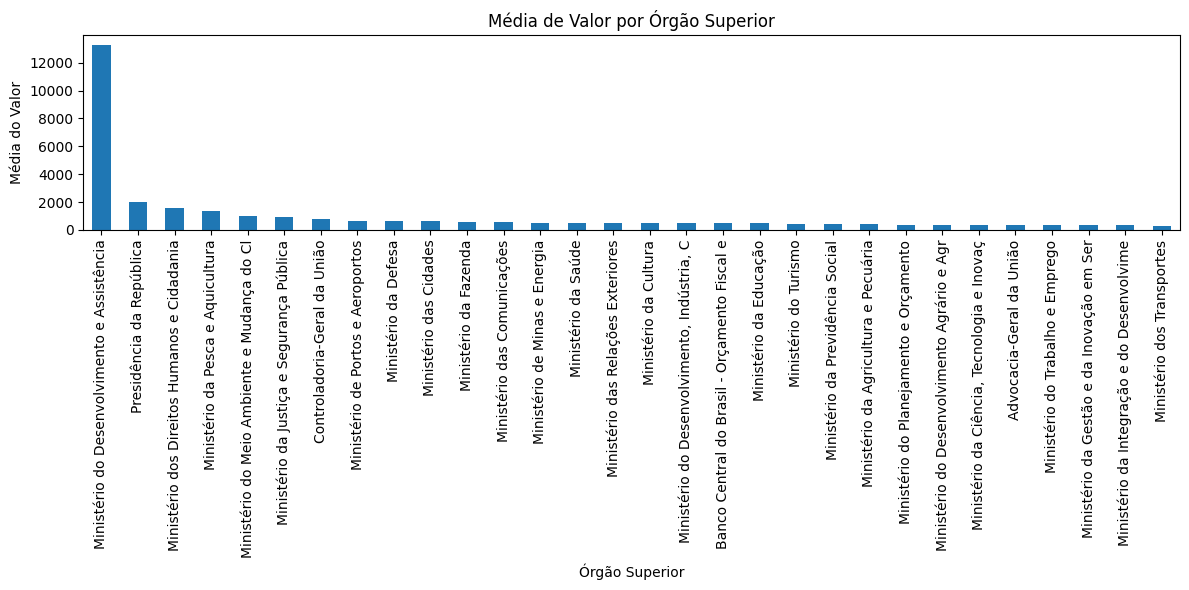

In [27]:
summary_orgao_superior.plot(kind='bar', figsize=(12,6), legend = False)
plt.title("Média de Valor por Órgão Superior")
plt.ylabel("Média do Valor")
plt.xlabel("Órgão Superior")
plt.tight_layout()
plt.show();

In [51]:
### Agregado por órgão

summary_orgao = (
    CPGF_df.groupby("NOME ÓRGÃO")["VALOR TRANSAÇÃO"]
      .agg([
          ("mean", "mean"),
      ])
      .sort_values("mean", ascending=False)
).reset_index()

summary_orgao

,NOME ÓRGÃO,mean
0,Ministério do Desenvolvimento e Assistência So...,13305.433333
1,"VALEC Engenharia, Construções e Ferrovias S.A.",4505.762857
2,Fundação Universidade Federal de Rondônia,2666.174588
3,Presidência da República,2353.340130
4,Universidade Federal de Roraima,1687.500000
...,...,...
189,Fundação Universidade Federal do ABC,168.832192
190,Fundação Osório,142.311200
191,Caixa de Construções de Casas para o Pessoal d...,140.446531
192,Universidade Federal do Rio Grande,121.480758


/tmp/ipykernel_134671/880931377.py:6: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


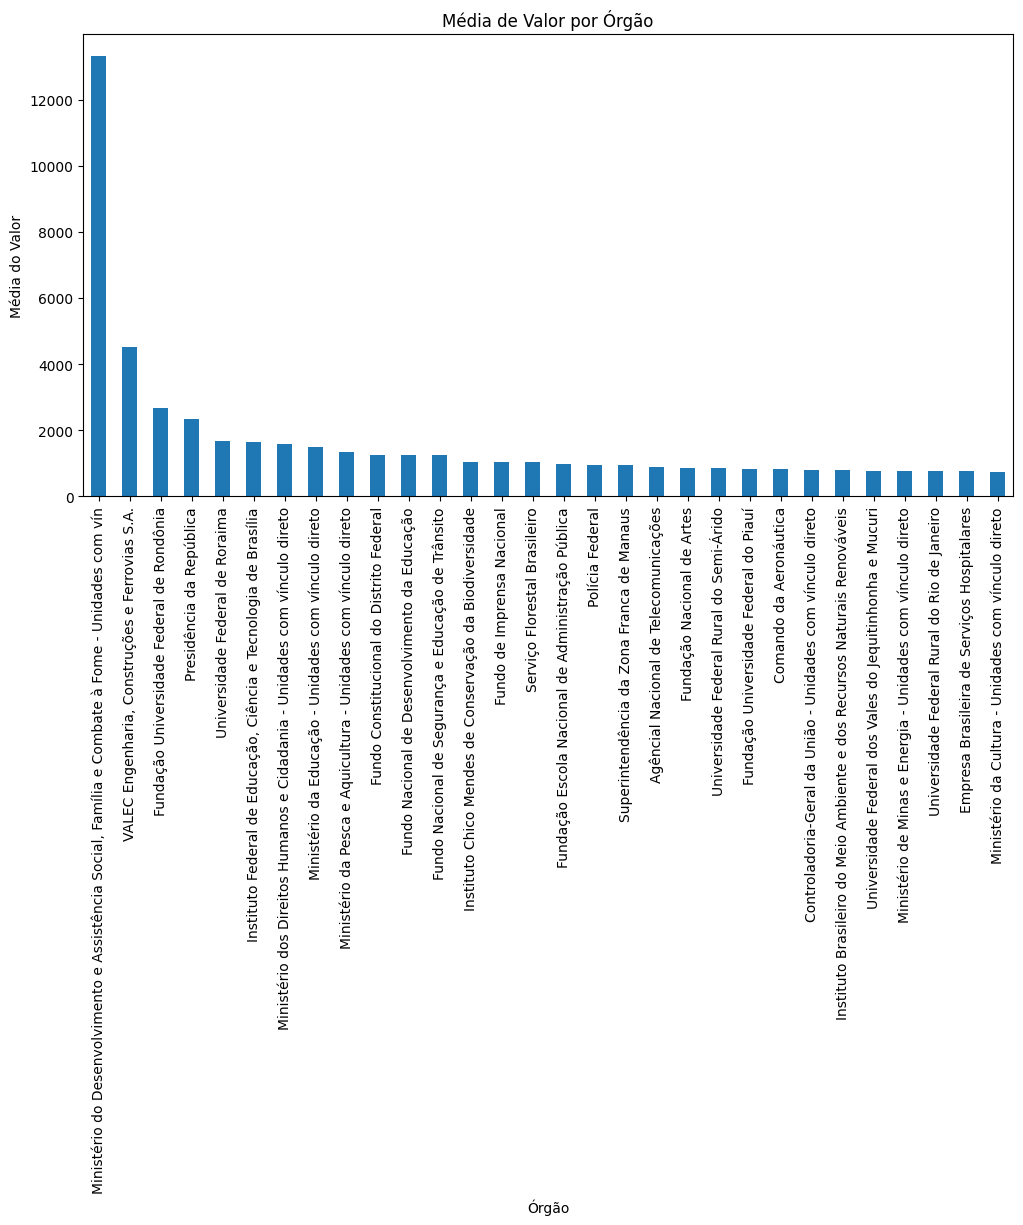

In [32]:
top_30_orgao = summary_orgao.head(30)
top_30_orgao.plot(kind='bar', figsize = (12,6), legend=False)
plt.title("Média de Valor por Órgão")
plt.ylabel("Média do Valor")
plt.xlabel("Órgão")
plt.tight_layout()
plt.show();

In [52]:
### Agregado por unidade gestora

summary_unidade_gestora = (
    CPGF_df.groupby("NOME UNIDADE GESTORA")["VALOR TRANSAÇÃO"]
      .agg([
          ("mean", "mean"),
      ])
      .sort_values("mean", ascending=False)
).reset_index()

summary_unidade_gestora

,NOME UNIDADE GESTORA,mean
0,62 BATALHAO DE INFANTARIA,16146.000000
1,COORDENACAO GERAL DE LICITACOES E CONTRATOS.,13305.433333
2,FCDF±SSP ± POLICIA MILITAR DO DF,9831.068182
3,1º BATALHAO DE INFANTARIA MECANIZADO (ES),6957.910000
4,BATALHAO MANUTENCAO E SUPRIMENTO DE ARMAMENTO,5506.500000
...,...,...
1267,DELEGACIA DA RFB EM VOLTA REDONDA,17.400000
1268,COLEGIO MILITAR DE JUIZ DE FORA,10.950000
1269,INST.FED.DO RN/CAMPUS NATAL - CENTRAL,8.900000
1270,CMDO DE DEFESA ANTIAEREA DO EXERCITO,3.000000


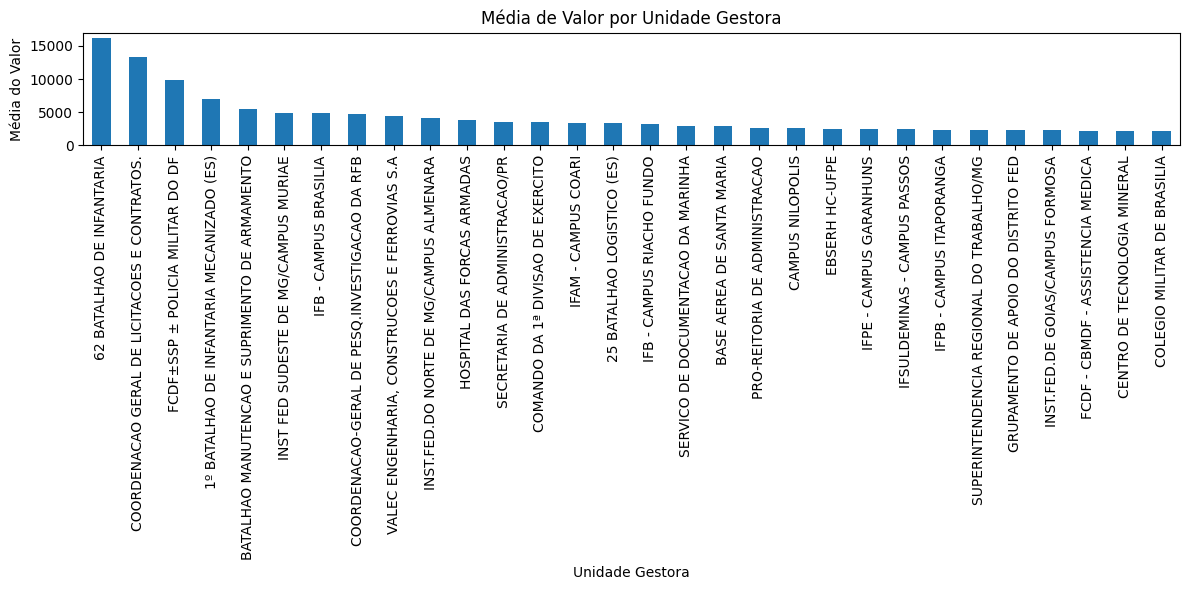

In [37]:
top_30_unidade_gestora = summary_unidade_gestora.head(30)
top_30_unidade_gestora.plot(kind='bar', figsize = (12,6), legend=False)
plt.title("Média de Valor por Unidade Gestora")
plt.ylabel("Média do Valor")
plt.xlabel("Unidade Gestora")
plt.tight_layout()
plt.show();

In [53]:
### Agregado por Estado

summary_estado = (
    CPGF_df.groupby("ESTADO_ESTIMADO")["VALOR TRANSAÇÃO"]
      .agg([
          ("mean", "mean"),
      ])
      .sort_values("mean", ascending=False)
).reset_index()

summary_estado

,ESTADO_ESTIMADO,mean
0,PR,1843.534327
1,SE,870.031822
2,AP,781.078783
3,AM,740.434064
4,AC,668.404394
5,UNIÃO,640.721899
6,RR,628.806931
7,RJ,581.257184
8,PA,576.642688
9,DF,566.289024


In [43]:
PR_df = CPGF_df[CPGF_df['ESTADO_ESTIMADO'] == 'PR'].sort_values('VALOR TRANSAÇÃO', ascending=False)
PR_df.head(2)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO ORIGEM,DADO_SIGILOSO,ESTADO_ESTIMADO,ID_portador,fim_semana
392007,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,5,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,2024-05-01,207953.60,202405_CPGF.csv,1,PR,NaN,99
120020,20000,Presidência da República,20101,Presidência da República,110001,SECRETARIA DE ADMINISTRACAO/PR,2024,7,NaN,Sigiloso,-11,Sigiloso,Informações protegidas por sigilo,2024-07-01,196690.82,202407_CPGF.csv,1,PR,NaN,99


In [54]:
summary_PR = (
    PR_df.groupby("NOME UNIDADE GESTORA")["VALOR TRANSAÇÃO"]
      .agg([
          ("mean", "mean"),
          ("sum", "sum"),
      ])
      .sort_values("sum", ascending=False)
)

summary_PR

,mean,sum
NOME UNIDADE GESTORA,,
SECRETARIA DE ADMINISTRACAO/PR,3544.942670,18823645.58
SUPERINTENDENCIA ESTADUAL DO IBGE NO PARANA,290.057208,876842.94
DELEGACIA DE POLICIA FEDERAL EM FOZ DO IGUACU,865.369544,664603.81
SUPERINTENDENCIA REGIONAL NO ESTADO DO PR,718.069392,283637.41
UTFPR - CAMPUS CURITIBA,457.176024,267905.15
SUPERINT.DE AGRICULTURA E PECUARIA - SFA/PR,343.619520,93120.89
IBAMA - SUPERINTENDENCIA DO PARANA/PR,897.646795,70016.45
SUPERINT REG DO TRAB E EMPREGO/PR,371.743333,57991.96
BANCO CENTRAL DO BRASIL - CURITIBA,326.753333,51953.78


In [47]:
PR_df[PR_df['NOME UNIDADE GESTORA'] == 'SUPERINT REG DO TRAB E EMPREGO/PR'].sort_values('VALOR TRANSAÇÃO', ascending=False)

,CÓDIGO ÓRGÃO SUPERIOR,NOME ÓRGÃO SUPERIOR,CÓDIGO ÓRGÃO,NOME ÓRGÃO,CÓDIGO UNIDADE GESTORA,NOME UNIDADE GESTORA,ANO EXTRATO,MÊS EXTRATO,CPF PORTADOR,NOME PORTADOR,CNPJ OU CPF FAVORECIDO,NOME FAVORECIDO,TRANSAÇÃO,DATA TRANSAÇÃO,VALOR TRANSAÇÃO,ARQUIVO ORIGEM,DADO_SIGILOSO,ESTADO_ESTIMADO,ID_portador,fim_semana
207327,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2025,8,***.554.459-**,VINICIUS BATISTA FRANKLIN,81825013934,MERCEDES FERNANDES FESTI,COMPRA A/V - R$ - APRES,2025-07-23,1963.31,202508_CPGF.csv,0,PR,***.554.459-**VINICIUS BATISTA FRANKLIN,0
207329,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2025,8,***.554.459-**,VINICIUS BATISTA FRANKLIN,81825013934,MERCEDES FERNANDES FESTI,COMPRA A/V - R$ - APRES,2025-07-23,1900.00,202508_CPGF.csv,0,PR,***.554.459-**VINICIUS BATISTA FRANKLIN,0
81916,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2025,5,***.159.529-**,NILSA MIGUEL DOS SANTOS,5798147000192,INNERBIT INFORMATICA LTDA,COMPRA A/V - R$ - APRES,2025-04-11,1894.95,202505_CPGF.csv,0,PR,***.159.529-**NILSA MIGUEL DOS SANTOS,0
166471,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2024,11,***.801.049-**,RICARDO ALEXANDRE HONORIO ALVES,76703800000130,VIDRACARIA PARANA LTDA,COMPRA A/V - R$ - APRES,2024-10-15,1690.00,202411_CPGF.csv,0,PR,***.801.049-**RICARDO ALEXANDRE HONORIO ALVES,0
326514,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2024,12,***.515.179-**,LUIZ FERNANDO FAVARO BUSNARDO,77583367000100,PANIFICADORA E CONFEITARIA GEMA LTDA,COMPRA A/V - R$ - APRES,2024-11-13,1499.00,202412_CPGF.csv,0,PR,***.515.179-**LUIZ FERNANDO FAVARO BUSNARDO,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81919,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2025,5,***.801.049-**,RICARDO ALEXANDRE HONORIO ALVES,76487000196,CODIFRIO FORNECEDORA DE PECAS PARA ELETRODOMES...,COMPRA A/V - R$ - APRES,2025-04-04,14.00,202505_CPGF.csv,0,PR,***.801.049-**RICARDO ALEXANDRE HONORIO ALVES,0
81912,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2025,5,***.801.049-**,RICARDO ALEXANDRE HONORIO ALVES,77044618003365,BALAROTI - COMERCIO DE MATERIAIS DE CONSTRUCAO...,COMPRA A/V - R$ - APRES,2025-04-10,11.60,202505_CPGF.csv,0,PR,***.801.049-**RICARDO ALEXANDRE HONORIO ALVES,0
67159,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2024,10,***.801.049-**,RICARDO ALEXANDRE HONORIO ALVES,92660406000380,FRIGELAR COMERCIO E INDUSTRIA LTDA,COMPRA A/V - R$ - APRES,2024-09-09,10.00,202410_CPGF.csv,0,PR,***.801.049-**RICARDO ALEXANDRE HONORIO ALVES,0
67152,38000,Ministério do Trabalho e Emprego,38000,Ministério do Trabalho e Emprego - Unidades co...,380044,SUPERINT REG DO TRAB E EMPREGO/PR,2024,10,***.801.049-**,RICARDO ALEXANDRE HONORIO ALVES,77044618003365,BALAROTI - COMERCIO DE MATERIAIS DE CONSTRUCAO...,COMPRA A/V - R$ - APRES,2024-09-06,9.88,202410_CPGF.csv,0,PR,***.801.049-**RICARDO ALEXANDRE HONORIO ALVES,0


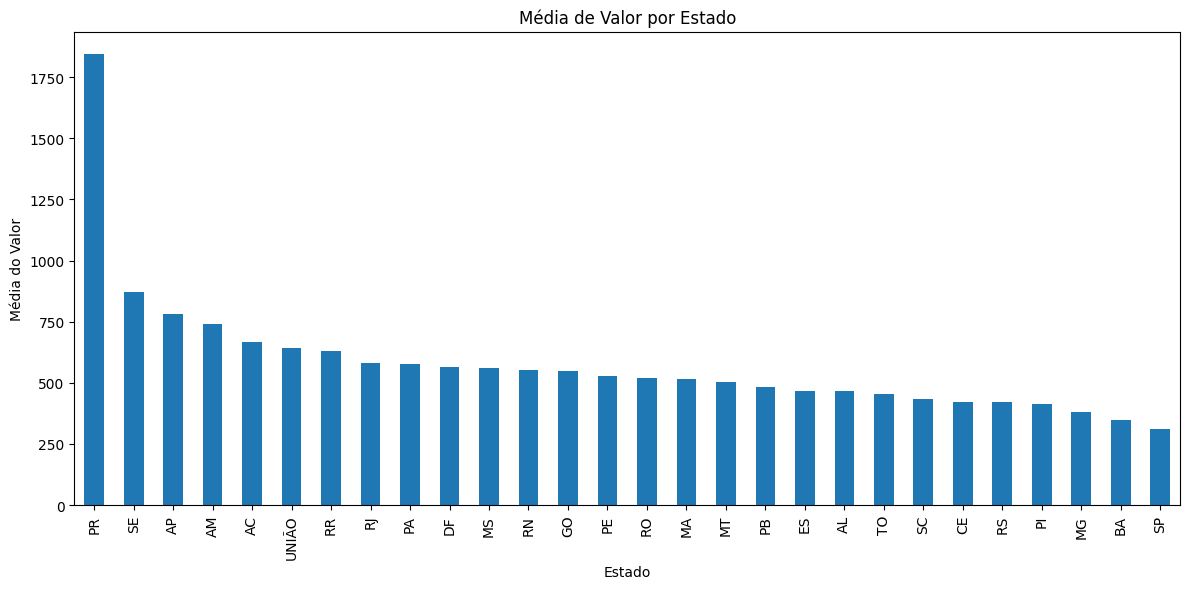

In [36]:
summary_estado.plot(kind='bar', figsize = (12,6), legend=False)
plt.title("Média de Valor por Estado")
plt.ylabel("Média do Valor")
plt.xlabel("Estado")
plt.tight_layout()
plt.show();

In [ ]:
def feature_engineering(df):
    # ID_portador column
    df["ID_portador"] = df["CPF PORTADOR"] + df["NOME PORTADOR"]

    # Weekend column (including "SIGILOSO" rule)
    df["fim_semana"] = np.where(
        df['DADO_SIGILOSO'] == 1,
        99,
        df['DATA TRANSAÇÃO'].dt.day_of_year.isin([5, 6]).astype(int)
    )

    return df